**TinyML : Activity Recognition**

**Goals:**

Download the dataset and visualize the accelerometer signals

Train and test a Tensorflow classifier on the data given

Convert the model to TFLite format and make it ready for deploying on device.

Setup Arduino board and view accelerometer signals live from it.

Deploy the model on the Arduino board

Test the model prediction on the go: when you do the movements yourself!



**Dataset description:**

Jump (🫳): hold the Arduino board in the hand and lift the hand. The csv file has around 70 jump.

Idle: The board is left idle on the table.

# Necessary Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.18.0



# Visualization

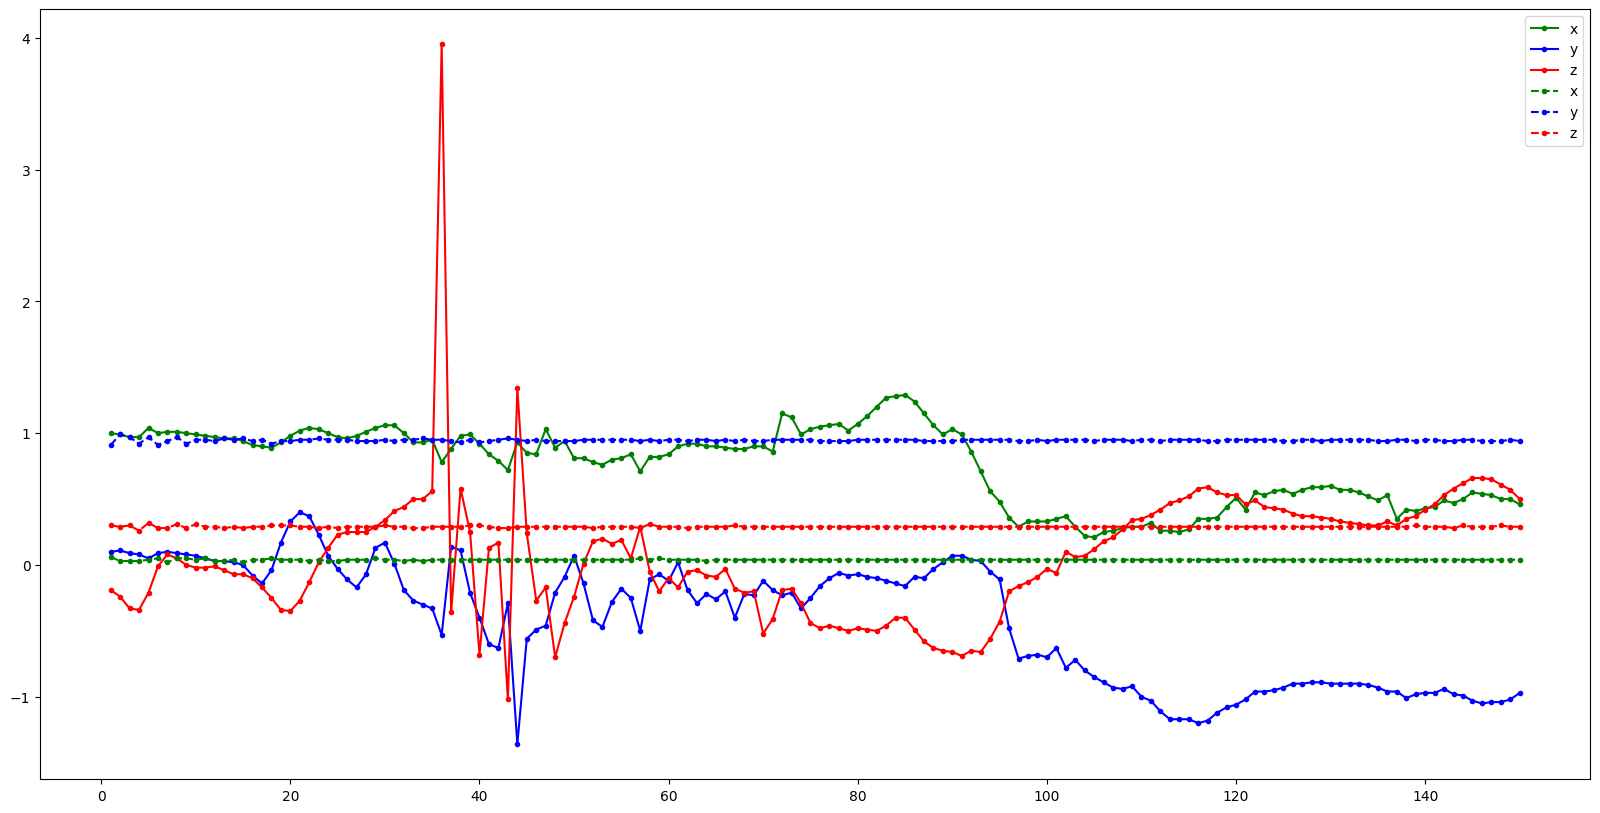

In [ ]:
# This function plots the first 1000 values from the recorded signal.
# Take a look at the signal and clearly it is hard to differenciate the classes by seeing the plots

def plot_ts(df, ax = None, ls = '-'):
  num=150
  index = np.arange(1, len(df['aX']) + 1)
  ax.plot(index[:num], df['aX'].values[:num], 'g.', label='x', linestyle=ls)
  ax.plot(index[:num], df['aY'].values[:num], 'b.', label='y', linestyle=ls)
  ax.plot(index[:num], df['aZ'].values[:num], 'r.', label='z', linestyle=ls)

fig, ax = plt.subplots(figsize=(20, 10))
df = pd.read_csv("jump.csv", names = ['aX', 'aY', 'aZ'], delimiter='\t')
plot_ts(df, ax, ls='-')
df = pd.read_csv("idle.csv", names = ['aX', 'aY', 'aZ'], delimiter='\t')
plot_ts(df, ax, ls='dashed')

plt.legend()
plt.show()

# Tensorflow Training, model building

In [ ]:
# === Step 1: Load data ===

jump_data = np.loadtxt("jump.csv", delimiter="\t", skiprows=1)# shape: (N, 3)
idle_data = np.loadtxt("idle.csv", delimiter="\t", skiprows=1)# shape: (N, 3)

# === Step 2: Create labels ===
jump_labels = np.ones((jump_data.shape[0], 1))   # Label = 1 for jump
idle_labels = np.zeros((idle_data.shape[0], 1))  # Label = 0 for idle

# === Step 3: Combine data ===
X = np.vstack((idle_data, jump_data))  # ax, ay, az
y = np.vstack((idle_labels, jump_labels)).astype(int)

# === Step 4: Preprocess ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode labels
y_cat = tf.keras.utils.to_categorical(y, num_classes=2)

# === Step 5: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# === Step 6: Build a super small model ===
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),               # ax, ay, az
    tf.keras.layers.Dense(4, activation='relu'),     # Tiny hidden layer
    tf.keras.layers.Dense(2, activation='softmax')   # Output layer for 2 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 7: Train ===
history=model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# === Step 8: Evaluate ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

# === Step 9: Convert to TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Lightweight!
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("model.tflite generated successfully!")


Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7411 - loss: 0.6150 - val_accuracy: 0.9777 - val_loss: 0.1081
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9853 - loss: 0.0850 - val_accuracy: 0.9958 - val_loss: 0.0354
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9957 - loss: 0.0348 - val_accuracy: 0.9971 - val_loss: 0.0196
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9971 - loss: 0.0201 - val_accuracy: 0.9979 - val_loss: 0.0129
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9979 - loss: 0.0139 - val_accuracy: 0.9985 - val_loss: 0.0090
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9984 - loss: 0.0099 - val_accuracy: 0.9993 - val_loss: 0.0067
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9986 - loss: 0.0091 - val_accuracy: 0.9993 - val_loss: 0.0054
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9992 - loss: 0.0069 - 

# Plot training statistics

In [ ]:
# === Step 10: Training/Validation accuracy over epochs plot (a learning curve) ===
def plot_train_val_statistics(training_statistics, validation_statistics, statistics_name='accuracy'):
    plt.figure(figsize=(8, 6))
    plt.plot(training_statistics)
    plt.plot(validation_statistics)
    plt.title(statistics_name)
    plt.ylabel(statistics_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

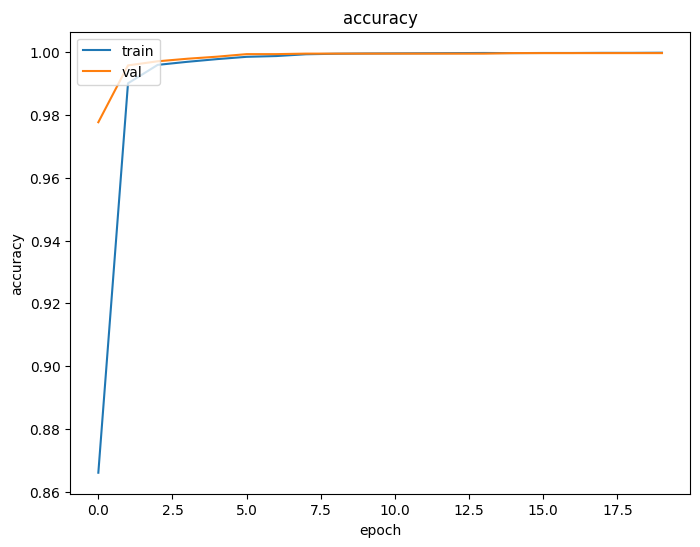

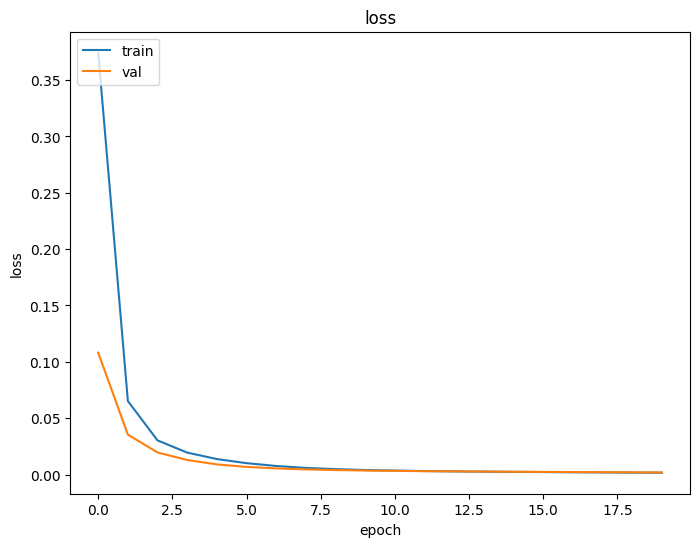

In [ ]:
#Function calls
plot_train_val_statistics(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
plot_train_val_statistics(history.history['loss'], history.history['val_loss'], 'loss')

In [ ]:
# Results on the test set
performance = model.evaluate(x=X_test, y=y_test)
print(''.join([f"{name}={value:.05f}  " for name, value in zip(model.metrics_names, performance)]))

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0016
loss=0.00182  compile_metrics=0.99967  


In [ ]:
# Convert the trained TensorFlow Lite model (.tflite) into a C array
# so it can be included in the Arduino sketch as a header file.
# This generates 'model.h' containing the binary model data.
!xxd -i model.tflite > model.h

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


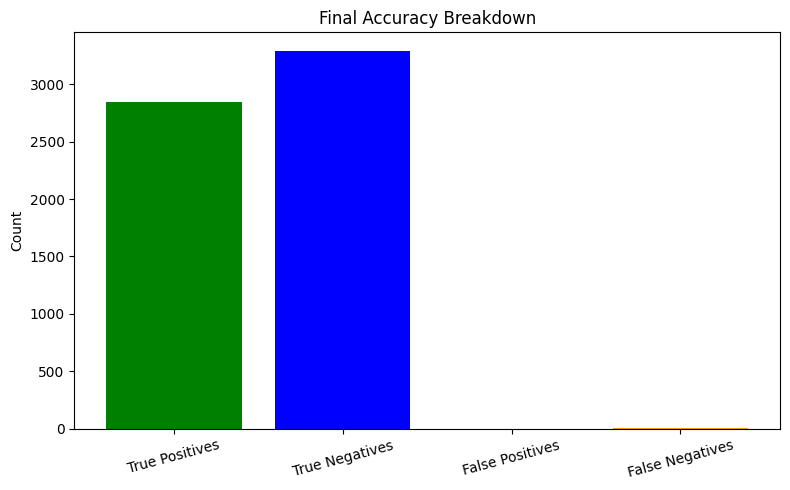

In [ ]:
# === Step 11: Predict on Test Set ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# === Step 12: Compute Confusion Matrix ===
cm = confusion_matrix(y_true_classes, y_pred_classes)

# cm layout:
# [ [TN, FP],
#   [FN, TP] ]

TN, FP, FN, TP = cm.ravel()

# === Step 13: Accuracy Breakdown Bar Chart ===
labels = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
values = [TP, TN, FP, FN]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['green', 'blue', 'red', 'orange'])
plt.title('Final Accuracy Breakdown')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


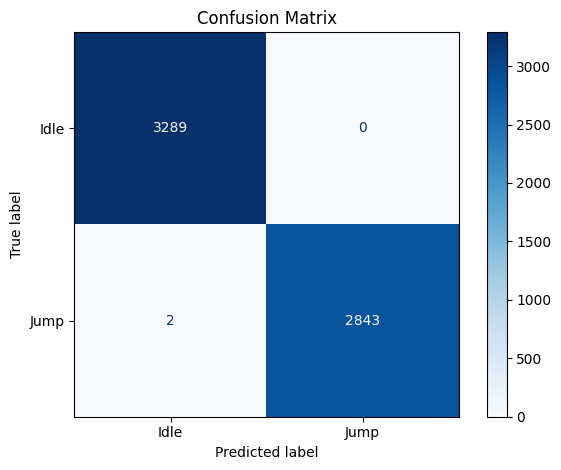

In [ ]:
# === Step 14:Show Confusion Matrix ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Idle", "Jump"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
